In [380]:
# import necessary libraries
import numpy as np
import pandas as pd
import scipy
from scipy.stats import zscore
import csv
import sklearn
from sklearn import decomposition
import matplotlib.pyplot as plt
import pdb
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
import statsmodels.tools.tools as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score, train_test_split
from rnanorm import CPM

### preparing data

In [434]:
blood_count_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE137092_blood_count_df.csv', index_col=0)
blood_samp_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE137092_blood_samp_df.csv', index_col=0)
blood_count_df.set_index('ID', inplace=True)

In [435]:
# writing a function to preprocess data
def preprocess(count_df, cpm=False, normalize=False, log2trans=False):
    # assumes that count_df is a RNA seq dataframe with genes on the rows and samples on the columns
    count_df_T = count_df.T #genes on cols, samps on rows
    if cpm:
        count_df_T = CPM().set_output(transform="pandas").fit_transform(count_df_T)
    if normalize:
        count_df_T = zscore(count_df_T, axis=1) #zscore across the cols (genes)
    if log2trans:
        count_df_T = np.log2(count_df_T + 1) #avoid division by 0 by +1
    return count_df_T.T

blood_count_df = preprocess(blood_count_df, normalize=True)
# blood_count_df.head()

In [498]:
lung_count_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE137093_lung_count_df.csv', index_col=0)
lung_samp_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE137093_lung_samp_df.csv', index_col=0)
lung_count_df.set_index('ID', inplace=True)
# lung_count_df.head()

In [499]:
lung_count_df = preprocess(lung_count_df, normalize=True)

In [144]:
array_count_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE140943_array_count_df.csv', index_col=0)
array_samp_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE140943_array_samp_df.csv', index_col=0)
# array_count_df.head()

In [145]:
array_count_df = preprocess(array_count_df, normalize=True)

In [461]:
ldn_count_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE107991_london_count_df.csv', index_col=0)
ldn_samp_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE107991_london_samp_df.csv', index_col=0)
ldn_count_df.drop(columns=['Gene_name', 'Gene_biotype'], inplace=True)

# ldn_count_df.head()

In [382]:
sa_count_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE107992_sa_count_df.csv', index_col=0)
sa_samp_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE107992_sa_samp_df.csv', index_col=0)
sa_count_df.drop(columns=['Gene_name', 'Gene_biotype'], inplace=True)

# sa_count_df.head()

# attempting to predict tb strain from mouse tb data (blood, lung, blood array)

## blood data

In [436]:
m = blood_count_df.values
strain = np.array(blood_samp_df['mtb_strain'].tolist())

In [437]:
m = m.T

### pca for clustering fun

In [7]:
pca = decomposition.PCA(n_components = 88)
pca.fit(m)
m_transformed = pca.transform(m)

<Axes: >

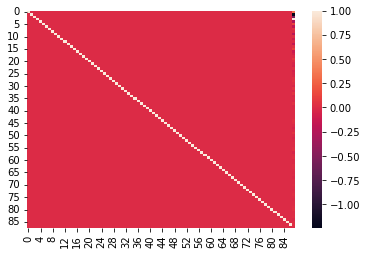

In [16]:
covmat_output = np.cov(m_transformed,rowvar=False) # !TO DO!
covmat_output = covmat_output/np.max(covmat_output,axis=0)

sns.heatmap(covmat_output)

Text(0, 0.5, 'Variance Explained')

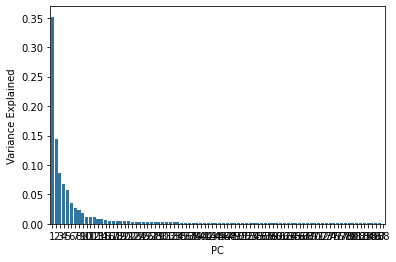

In [17]:
explained_variance = pca.explained_variance_ratio_

ax = sns.barplot(y=explained_variance, x = [str(x+1) for x in np.arange(len(explained_variance))])
ax.set_xlabel("PC")
ax.set_ylabel("Variance Explained")

Text(0, 0.5, 'PC2')

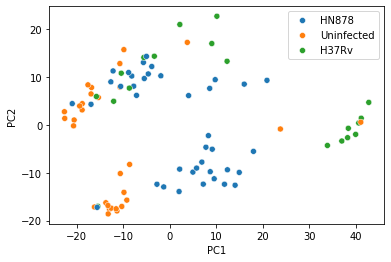

In [9]:
first_2_pcs = m_transformed[:, 0:2]

ax = sns.scatterplot(x = first_2_pcs[:, 0], y = first_2_pcs[:, 1], hue = strain)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

thoughts: 2 PCs explain about 50% of the data. the clustering is not apparent at ALL, so it would be interesting to do hierarchical clustering and kmeans to see if anything results.

visually it looks good
kmeans disagrees that those are the three clusters

In [ ]:
sns.clustermap(blood_count_df, cmap='RdBu_r', center=0, col_colors=samp_colors)

In [12]:
# from scipy.cluster import hierarchy

# # Perform hierarchical clustering
# linkage = hierarchy.linkage(blood_count_df, method='average')

# # Plot heatmap with dendrogram
# sns.heatmap(blood_count_df, cmap='RdBu_r', center=0)

In [20]:
strain_color = dict(zip(np.unique(strain), [[16, 37, 66], [248, 112, 96], [205, 215, 214]]))
print(strain_color)

{'H37Rv': [16, 37, 66], 'HN878': [248, 112, 96], 'Uninfected': [205, 215, 214]}


In [21]:
samp_colors = blood_samp_df['mtb_strain'].map(strain_color)
print(samp_colors)

GSM4066715     [248, 112, 96]
GSM4066716     [248, 112, 96]
GSM4066717     [248, 112, 96]
GSM4066718     [248, 112, 96]
GSM4066719     [248, 112, 96]
                   ...       
GSM4190571    [205, 215, 214]
GSM4190572    [205, 215, 214]
GSM4190573    [205, 215, 214]
GSM4190574    [205, 215, 214]
GSM4190575    [205, 215, 214]
Name: mtb_strain, Length: 88, dtype: object


Text(0, 0.5, 'PC2')

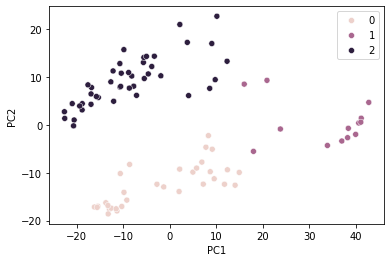

In [11]:
#trying kmeans clustering to see what groups come out
from sklearn.cluster import KMeans

# fit a kmeans model to our first_2_pcs objects; use n_clusters=2, random_state=2022, n_init=10
kmeanModel = KMeans(n_clusters=3,random_state=2022,n_init=10).fit(first_2_pcs) # !TO DO!

# grab the cluster labels from your kmeans model
kmeans_labels = kmeanModel.labels_ # !TO DO!

# remake the scatterplot from above, but color by kmeans_labels
ax = sns.scatterplot(x=first_2_pcs[:,0],y=first_2_pcs[:,1],hue=kmeans_labels) # !TO DO!
ax.set_xlabel("PC1"); ax.set_ylabel("PC2") # !TO DO!

In [16]:
blood_count_df = blood_count_df.T

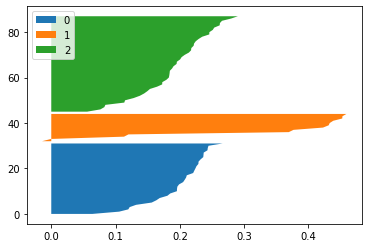

In [17]:
from sklearn.metrics import silhouette_samples
allLabels = np.unique(kmeans_labels)

silhouette_values = silhouette_samples(blood_count_df, kmeans_labels)

curY = 0
for i in range(len(allLabels)):
  curValues = np.sort(silhouette_values[kmeans_labels == allLabels[i]])
  plt.fill_betweenx(np.arange(curY, curY + len(curValues)), 0, curValues)
  curY += len(curValues)
plt.legend(allLabels, loc='upper left')

it's obvious that the clustering isn't great... especially with the PC space. let's see how well it performs as a predictive model, lol!

### pls-da for predictive model

In [19]:
blood_count_df.head()

,GRA502A536,GRA502A537,GRA502A538,GRA502A539,GRA502A540,GRA502A541,GRA502A542,GRA502A543,GRA502A544,GRA502A545,...,GRA502A646,GRA502A647,GRA502A648,GRA502A649,GRA502A650,GRA502A651,GRA502A652,GRA502A653,GRA502A654,GRA502A655
ID,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,1.485899,1.671134,1.555076,1.442187,1.548789,1.614619,1.681771,1.379020,1.620548,1.549193,...,1.697130,1.556223,1.537521,1.694572,1.589772,1.549806,1.490230,1.311393,1.397025,1.626553
ENSMUSG00000000003,-0.900689,-0.868295,-0.869107,-0.846087,-0.869064,-0.861117,-0.860446,-0.855791,-0.841295,-0.852124,...,-0.855437,-0.862571,-0.911397,-0.875787,-0.843533,-0.861131,-0.859909,-0.847875,-0.852674,-0.869752
ENSMUSG00000000028,0.171921,0.354737,0.404699,0.499423,0.416173,0.185789,0.103706,0.068332,0.204837,0.283929,...,0.123261,0.174784,-0.076705,0.093449,0.038435,-0.144645,-0.204094,-0.213888,-0.243744,-0.252315
ENSMUSG00000000037,-0.815306,-0.788234,-0.778863,-0.846087,-0.778084,-0.861117,-0.769983,-0.855791,-0.591559,-0.667626,...,-0.683199,-0.690123,-0.783745,-0.875787,-0.715712,-0.693777,-0.667678,-0.847875,-0.603017,-0.502486
ENSMUSG00000000049,-0.900689,-0.755119,-0.741551,-0.846087,-0.687401,-0.690327,-0.679828,-0.610761,-0.591559,-0.650112,...,-0.855437,-0.862571,1.632842,0.093449,-0.622652,-0.656348,-0.667678,-0.847875,-0.740649,-0.718734


In [438]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [439]:
X_data = blood_count_df.T #put features on the cols, samples on rows
Y = strain

In [440]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y, test_size=0.3, random_state=13)
# randomly chose 0.3 test size

In [441]:
Y_prob = np.array([(Y == 'Uninfected'), (Y == 'HN878'), (Y == 'H37Rv')]).T
Y_prob = Y_prob.astype(int)
Y_prob.shape

(88, 3)

In [442]:
Y_train_prob = np.array([(Y_train == 'Uninfected'), (Y_train == 'HN878'), (Y_train == 'H37Rv')]).T
# print(Y_train_prob)
Y_train_prob = Y_train_prob.astype(int)
print(np.argmax(Y_train_prob, axis=1))

[1 0 0 0 2 1 0 1 2 2 0 0 0 0 2 1 1 1 1 1 2 0 2 0 1 2 1 2 0 0 1 2 1 0 0 0 0
 0 0 1 1 0 0 1 1 2 1 2 1 0 1 0 2 1 0 1 0 1 1 2 1]


In [443]:
# build a model, first try 
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)
model.fit(X_train,Y_train_prob)


## reminder that you can go to sklearn documentation to see what the model object contains

# plsr_df = pd.DataFrame(data=model.x_scores_,columns=['Latent_Variable_{}'.format(x + 1) for x in range(ncomp)])
# plt.scatter(plsr_df.Latent_Variable_1,plsr_df.Latent_Variable_2, c=Y_train_prob,cmap='Greens' )
# plt.title('PLSR Scores Plot')
# plt.xlabel('Latent Variable 1')
# plt.ylabel('Latent Variable 2')
# cbar = plt.colorbar()
# cbar.solids.set_edgecolor("face")

Y_pred_prob = np.argmax(model.predict(X_test), axis=1)

In [444]:
Y_test_prob = np.array([(Y_test == 'Uninfected'), (Y_test == 'HN878'), (Y_test == 'H37Rv')]).T
# print(Y_train_prob)
Y_test_prob = Y_test_prob.astype(int)
Y_test_prob = np.argmax(Y_test_prob, axis=1)
# the vectors are as follows:
#[uninf, HN878, H37Rv]

In [445]:
from sklearn.metrics import accuracy_score, confusion_matrix
# accuracy from sklearn module
acc1 = accuracy_score(Y_test_prob, Y_pred) # TODO
print(f"PLS regression accuracy {acc1}")

# sensitiviy and specificity from confusion matrix
cm = confusion_matrix(Y_test_prob, Y_pred) # TODO
print(cm)
# for 2x2 confusion matrices
# # we define our positive label to be 1
# TN, FP, FN, TP = cm[0,0], cm[0, 1], cm[1, 0], cm[1,1]

# # check sensitivity
# sensitivity = TP / (TP + FN) # TODO
# specificity = TN / (TN + FP) # TODO
# ppv = TP / (TP + FP) # TODO
# npv = TN / (TN + FN) # TODO
# print(f"sensitivity = {sensitivity},\nspecificity = {specificity},\nppv = {ppv},\nnpv = {npv}\n")


#for 3x3 confusion matrices
# TN = cm[0, 0]
# FP = cm[0, 1] + cm[0, 2] + cm[1, 2] + cm[2, 1]
# FN = cm[1, 0] + cm[2, 0]
# TP = cm[1, 1] + cm[2, 2]
# # TP2 = cm[2, 2]
# # TN2 = cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1]
# # FP2 = cm[2, 0] + cm[2, 1]
# # FN2 = cm[0, 2] + cm[1, 2]
# sensitivity = TP / (TP + FN) # TODO
# specificity = TN / (TN + FP) # TODO
# ppv = TP / (TP + FP) # TODO
# npv = TN / (TN + FN) # TODO
# print(f"sensitivity = {sensitivity},\nspecificity = {specificity},\nppv = {ppv},\nnpv = {npv}\n")

# another convenient method by sklearn to easily access these metrics
from sklearn.metrics import classification_report
rep = classification_report(Y_test_prob, Y_pred)
print(rep)

rep = classification_report(Y_test_prob, Y_pred, output_dict = True)
# assert(sensitivity == rep["1"]["recall"])
# assert(specificity == rep["0"]["recall"])
# assert(ppv == rep["1"]["precision"])
# assert(npv == rep["0"]["precision"])

PLS regression accuracy 0.8148148148148148
[[ 6  0  0]
 [ 0 15  0]
 [ 3  2  1]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.88      1.00      0.94        15
           2       1.00      0.17      0.29         6

    accuracy                           0.81        27
   macro avg       0.85      0.72      0.67        27
weighted avg       0.86      0.81      0.76        27



Text(33.0, 0.5, 'True')

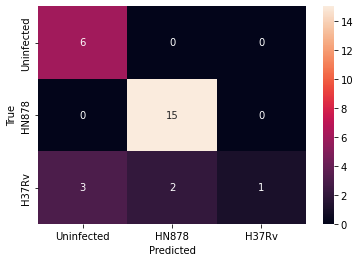

In [448]:
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", xticklabels=['Uninfected', 'HN878', 'H37Rv'], yticklabels=['Uninfected', 'HN878', 'H37Rv'])
plt.xlabel('Predicted')
plt.ylabel('True')

f1 score:
0,1,2 doesn't line up with the labels
need to figure out which lines up with my data (0.94 probably)


In [110]:
# 10 fold cross val
kf = KFold(n_splits=10) 
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)

curX = X_data.values
curY = Y_prob

accuracy_scores = []
r2_values = []

predY = np.zeros(Y_prob.shape)
for train_index, test_index in kf.split(curX):
    trainX = curX[train_index]
    testX = curX[test_index]
    trainY = curY[train_index] # TODO
    testY = curY[test_index]
    
    model.fit(trainX, trainY)
    predY[test_index] = model.predict(testX) # TODO

    Y_pred_classes = np.argmax(predY[test_index], axis=1)
    Y_test_classes = np.argmax(Y_prob[test_index], axis=1)
    
    # Calculate accuracy score
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    accuracy_scores.append(accuracy)

In [111]:
print(accuracy_scores)

[0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.3333333333333333, 0.4444444444444444, 0.0, 0.8888888888888888, 1.0, 0.875, 1.0]


In [116]:
avg_accuracy = np.average(accuracy_scores)
print(avg_accuracy)

0.7208333333333333


## lung data

In [451]:
l = lung_count_df.values
lstrain = np.array(lung_samp_df['mtb_strain'].tolist())
l = l.T

### pca for clustering

In [452]:
pca = decomposition.PCA(n_components = 88)
pca.fit(l)
l_transformed = pca.transform(l)

Text(0, 0.5, 'Variance Explained')

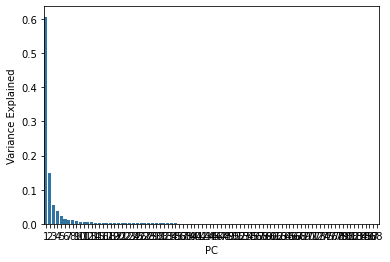

In [453]:
explained_variance = pca.explained_variance_ratio_

ax = sns.barplot(y=explained_variance, x = [str(x+1) for x in np.arange(len(explained_variance))])
ax.set_xlabel("PC")
ax.set_ylabel("Variance Explained")

Text(0, 0.5, 'PC2')

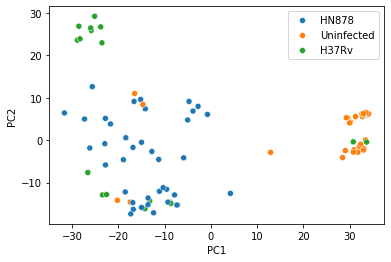

In [161]:
first_2_pcs = l_transformed[:, 0:2]

ax = sns.scatterplot(x = first_2_pcs[:, 0], y = first_2_pcs[:, 1], hue = lstrain)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

Text(0, 0.5, 'PC2')

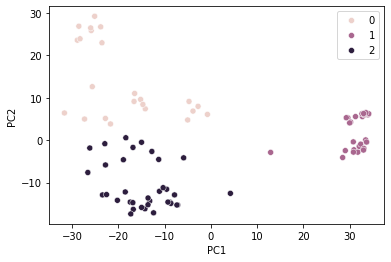

In [162]:
#trying kmeans clustering to see what groups come out
from sklearn.cluster import KMeans

# fit a kmeans model to our first_2_pcs objects; use n_clusters=2, random_state=2022, n_init=10
kmeanModel = KMeans(n_clusters=3,random_state=2022,n_init=10).fit(first_2_pcs) # !TO DO!

# grab the cluster labels from your kmeans model
kmeans_labels = kmeanModel.labels_ # !TO DO!

# remake the scatterplot from above, but color by kmeans_labels
ax = sns.scatterplot(x=first_2_pcs[:,0],y=first_2_pcs[:,1],hue=kmeans_labels) # !TO DO!
ax.set_xlabel("PC1"); ax.set_ylabel("PC2") # !TO DO!

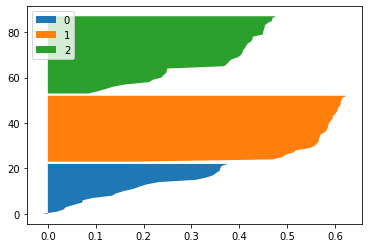

In [163]:
from sklearn.metrics import silhouette_samples
allLabels = np.unique(kmeans_labels)

silhouette_values = silhouette_samples(lung_count_df.T, kmeans_labels)

curY = 0
for i in range(len(allLabels)):
  curValues = np.sort(silhouette_values[kmeans_labels == allLabels[i]])
  plt.fill_betweenx(np.arange(curY, curY + len(curValues)), 0, curValues)
  curY += len(curValues)
plt.legend(allLabels, loc='upper left')

the clustering is SO GOOD?!?!?!?!?!? this is so exciting! this makes sense also because TB is a respiratory thing

### pls-da for predictive model

In [183]:
X_data.head()

,ILMN_1212602,ILMN_1212603,ILMN_1212605,ILMN_1212607,ILMN_1212612,ILMN_1212614,ILMN_1212619,ILMN_1212623,ILMN_1212625,ILMN_1212626,...,ILMN_3163529,ILMN_3163539,ILMN_3163543,ILMN_3163554,ILMN_3163567,ILMN_3163569,ILMN_3163572,ILMN_3163577,ILMN_3163581,ILMN_3163582
GSM4190920,-0.618482,-0.622443,0.473956,-0.559963,-0.488201,-0.556762,1.387847,-0.572930,0.524074,1.420896,...,0.304599,0.999977,0.178044,-0.578465,-0.581180,-0.332089,0.978041,-0.571817,-0.501817,-0.370814
GSM4190921,-0.599626,-0.559086,0.575597,-0.406374,-0.526707,-0.638827,1.423231,-0.533433,0.727717,1.093515,...,0.073090,1.150454,0.178391,-0.531974,-0.476815,-0.378297,1.014121,-0.492082,-0.519696,-0.038648
GSM4190922,-0.541925,-0.593517,0.467308,-0.321678,-0.524461,-0.567166,1.803975,-0.362339,0.841934,1.440789,...,0.400365,1.193481,0.137212,-0.585308,-0.465174,-0.243287,1.080226,-0.518736,-0.356907,-0.533000
GSM4190923,-0.586897,-0.580939,0.703758,-0.374931,-0.607961,-0.638787,1.393796,-0.470973,0.617569,0.719313,...,0.139269,1.389914,-0.219927,-0.633024,-0.606937,-0.283708,0.787885,-0.606937,-0.442450,-0.388648
GSM4190924,-0.626266,-0.547683,0.735806,-0.406387,-0.581108,-0.543757,1.442721,-0.555664,0.616126,0.288952,...,0.148120,1.529554,-0.174868,-0.604019,-0.488211,-0.446147,0.868453,-0.573105,-0.430802,-0.491444


In [490]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_data = lung_count_df.T #put features on the cols, samples on rows
Y = lstrain

Y_prob = np.array([(Y == 'Uninfected'), (Y == 'HN878'), (Y == 'H37Rv')]).T
Y_prob = Y_prob.astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y, test_size=0.3, random_state=13)

Y_train_prob = np.array([(Y_train == 'Uninfected'), (Y_train == 'HN878'), (Y_train == 'H37Rv')]).T
Y_train_prob = Y_train_prob.astype(int)

Y_test_prob = np.array([(Y_test == 'Uninfected'), (Y_test == 'HN878'), (Y_test == 'H37Rv')]).T
Y_test_prob = Y_test_prob.astype(int)
Y_test_prob = np.argmax(Y_test_prob, axis=1)

In [491]:
from sklearn.metrics import accuracy_score, confusion_matrix
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)
model.fit(X_train,Y_train_prob)

Y_pred_prob = np.argmax(model.predict(X_test), axis=1)

acc1 = accuracy_score(Y_test_prob, Y_pred_prob) # TODO
print(f"PLS regression accuracy {acc1}")

cm = confusion_matrix(Y_test_prob, Y_pred_prob) # TODO
print(cm)

PLS regression accuracy 0.7407407407407407
[[ 6  1  0]
 [ 0 13  1]
 [ 2  3  1]]


In [492]:
from sklearn.metrics import classification_report
rep = classification_report(Y_test_prob, Y_pred)
print(rep)

rep = classification_report(Y_test_prob, Y_pred, output_dict = True)

              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.82      1.00      0.90        14
           2       1.00      0.17      0.29         6

    accuracy                           0.78        27
   macro avg       0.83      0.67      0.65        27
weighted avg       0.82      0.78      0.73        27



Text(33.0, 0.5, 'True')

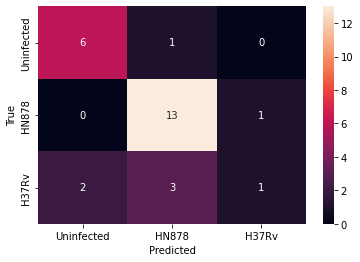

In [456]:
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", xticklabels=['Uninfected', 'HN878', 'H37Rv'], yticklabels=['Uninfected', 'HN878', 'H37Rv'])
plt.xlabel('Predicted')
plt.ylabel('True')

In [457]:
# 10 fold cross val
kf = KFold(n_splits=10) 
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)

curX = X_data.values
curY = Y_prob

accuracy_scores = []
r2_values = []

predY = np.zeros(Y_prob.shape)
for train_index, test_index in kf.split(curX):
    trainX = curX[train_index]
    testX = curX[test_index]
    trainY = curY[train_index] # TODO
    testY = curY[test_index]
    
    model.fit(trainX, trainY)
    predY[test_index] = model.predict(testX) # TODO

    Y_pred_classes = np.argmax(predY[test_index], axis=1)
    Y_test_classes = np.argmax(Y_prob[test_index], axis=1)
    
    # Calculate accuracy score
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    accuracy_scores.append(accuracy)

print(f'accuracy scores: {accuracy_scores}')

avg_accuracy = np.average(accuracy_scores)
print(f'average accuracy: {avg_accuracy}')

accuracy scores: [0.6666666666666666, 1.0, 0.7777777777777778, 0.1111111111111111, 0.3333333333333333, 0.1111111111111111, 1.0, 1.0, 0.875, 1.0]
average accuracy: 0.6875


bigger transcriptomic changes in the blood than in the lung, types of cells where RNAseq was collected from

## blood array data

In [153]:
a.shape

(26, 45281)

In [206]:
a = array_count_df.values
astrain = np.array(array_samp_df['agent'].tolist())
a = a.T

astrain = [1 if x == "Mycobacterium tuberculosis H37Rv" else 0 for x in astrain]

In [207]:
pca = decomposition.PCA(n_components = 26)
pca.fit(a)
a_transformed = pca.transform(a)

Text(0, 0.5, 'Variance Explained')

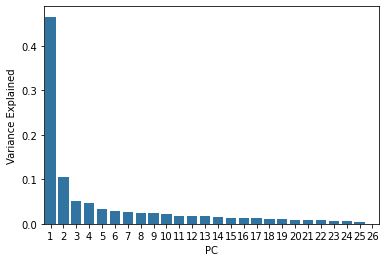

In [208]:
explained_variance = pca.explained_variance_ratio_

ax = sns.barplot(y=explained_variance, x = [str(x+1) for x in np.arange(len(explained_variance))])
ax.set_xlabel("PC")
ax.set_ylabel("Variance Explained")

Text(0, 0.5, 'PC2')

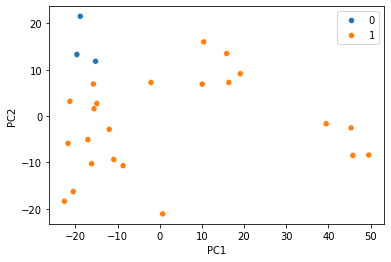

In [209]:
first_2_pcs = a_transformed[:, 0:2]

ax = sns.scatterplot(x = first_2_pcs[:, 0], y = first_2_pcs[:, 1], hue = astrain)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

Text(0, 0.5, 'PC2')

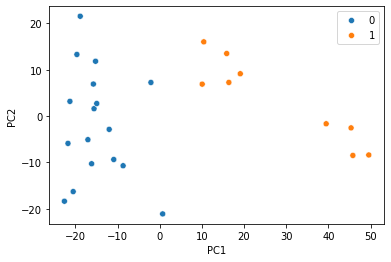

In [167]:
#trying kmeans clustering to see what groups come out
from sklearn.cluster import KMeans

# fit a kmeans model to our first_2_pcs objects; use n_clusters=2, random_state=2022, n_init=10
kmeanModel = KMeans(n_clusters=2,random_state=2022,n_init=10).fit(first_2_pcs) # !TO DO!

# grab the cluster labels from your kmeans model
kmeans_labels = kmeanModel.labels_ # !TO DO!

# remake the scatterplot from above, but color by kmeans_labels
ax = sns.scatterplot(x=first_2_pcs[:,0],y=first_2_pcs[:,1],hue=kmeans_labels) # !TO DO!
ax.set_xlabel("PC1"); ax.set_ylabel("PC2") # !TO DO!

### pls-da for predictive model

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_data = array_count_df.T #put features on the cols, samples on rows
Y = astrain

Y_prob = np.array([(0, 1) if x == 1 else (1, 0) for x in Y])
Y_prob = Y_prob.astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y, test_size=0.3, random_state=13)

Y_train_prob = np.array([(0, 1) if x == 1 else (1, 0) for x in Y_train])
Y_train_prob = Y_train_prob.astype(int)

Y_test_prob = np.array([(0, 1) if x == 1 else (1, 0) for x in Y_test])
# Y_test_prob = Y_test_prob.astype(int)
Y_test_prob = np.argmax(Y_test_prob, axis=1)

In [228]:
print(Y_test_prob)

[1 1 0 1 1 1 1 1]


In [229]:
from sklearn.metrics import accuracy_score, confusion_matrix
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)
model.fit(X_train,Y_train_prob)

Y_pred_prob = np.argmax(model.predict(X_test), axis=1)

acc1 = accuracy_score(Y_test_prob, Y_pred_prob) # TODO
print(f"PLS regression accuracy {acc1}")

cm = confusion_matrix(Y_test_prob, Y_pred_prob) # TODO
print(cm)

PLS regression accuracy 0.875
[[0 1]
 [0 7]]


In [230]:
# 10 fold cross val
kf = KFold(n_splits=10) 
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)

curX = X_data.values
curY = Y_prob

accuracy_scores = []
r2_values = []

predY = np.zeros(Y_prob.shape)
for train_index, test_index in kf.split(curX):
    trainX = curX[train_index]
    testX = curX[test_index]
    trainY = curY[train_index] # TODO
    testY = curY[test_index]
    
    model.fit(trainX, trainY)
    predY[test_index] = model.predict(testX) # TODO

    Y_pred_classes = np.argmax(predY[test_index], axis=1)
    Y_test_classes = np.argmax(Y_prob[test_index], axis=1)
    
    # Calculate accuracy score
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    accuracy_scores.append(accuracy)

print(f'accuracy scores: {accuracy_scores}')

avg_accuracy = np.average(accuracy_scores)
print(f'average accuracy: {avg_accuracy}')

C:\Users\jeann\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:300: UserWarning: Y residual is constant at iteration 0
  warnings.warn(f"Y residual is constant at iteration {k}")


accuracy scores: [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average accuracy: 0.9


ultimately i don't think the blood array data is that reliable since there are only 26 samples. overall i would think that the lung data is the most predictive!

# attempting to predict tb disease status from human tb data (london, south africa)

## train on london, test on SA

In [234]:
# let's cluster for fun at first
ldn_samp_df.head()

,title,group,outlier
GSM2886035,Berry_London_Sample1,Active_TB,No
GSM2886036,Berry_London_Sample2,Active_TB,Yes
GSM2886037,Berry_London_Sample3,LTBI,Yes
GSM2886038,Berry_London_Sample4,LTBI,No
GSM2886039,Berry_London_Sample5,Control,No


In [462]:
ldn_count_df.shape

(14150, 54)

In [501]:
ldn = ldn_count_df.values
severity = np.array(ldn_samp_df['group'].tolist())
ldn = ldn.T

In [502]:
pca = decomposition.PCA(n_components = 54)
pca.fit(ldn)
ldn_transformed = pca.transform(ldn)

ValueError: n_components=54 must be between 0 and min(n_samples, n_features)=42 with svd_solver='full'

Text(0, 0.5, 'Variance Explained')

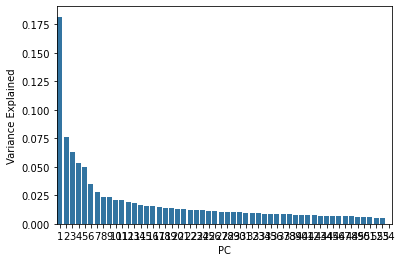

In [465]:
explained_variance = pca.explained_variance_ratio_

ax = sns.barplot(y=explained_variance, x = [str(x+1) for x in np.arange(len(explained_variance))])
ax.set_xlabel("PC")
ax.set_ylabel("Variance Explained")

Text(0, 0.5, 'PC2')

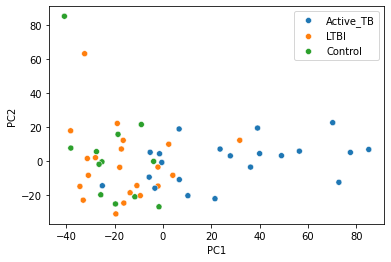

In [466]:
first_2_pcs = ldn_transformed[:, 0:2]

ax = sns.scatterplot(x = first_2_pcs[:, 0], y = first_2_pcs[:, 1], hue = severity)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

### ****try tSNE or uMAP clustering

In [411]:
print(ldn)

[[ 4.64700901e+00  4.68461941e+00  2.37909740e+00 ... -3.44363275e+00
   3.97759055e+00  8.92650641e-01]
 [ 4.19334378e+00  4.63385272e+00  2.10739177e+00 ... -4.66673300e-03
   4.47380733e+00  1.15287454e+00]
 [ 3.88787083e+00  4.35867562e+00  2.23336739e+00 ...  1.03919484e+00
   4.58491197e+00  8.28977137e-01]
 ...
 [ 4.38631501e+00  4.42072113e+00  2.31127557e+00 ... -3.08594065e+00
   4.18218358e+00  1.26657577e+00]
 [ 4.55846398e+00  4.55989381e+00  2.46005186e+00 ... -1.89596943e+00
   3.44000340e+00  1.39424981e+00]
 [ 5.26044284e+00  4.96712841e+00  2.03280234e+00 ... -6.75183251e+00
   2.05873913e+00 -6.02085387e-01]]


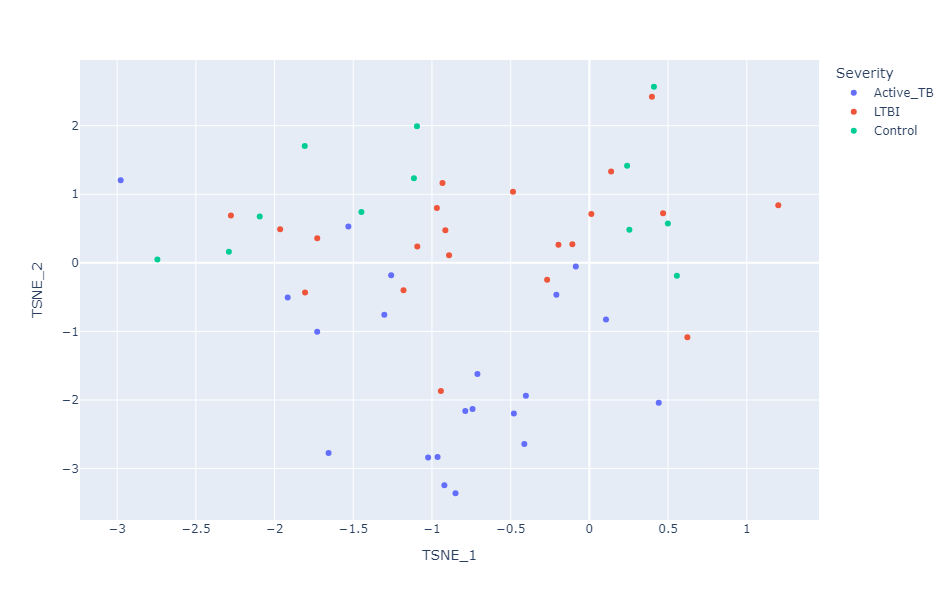

In [467]:
# from sklearn.manifold import TSNE
# import plotly.express as px

# df = ldn

# features = df.loc[:, :'petal_width']

# tsne = TSNE(n_components=2, random_state=0)
# projections = tsne.fit_transform(features)

# fig = px.scatter(
#     projections, x=0, y=1,
#     color=severity, labels={'color': 'severity'},
#     height=600,width=800
# )
# fig.show()

from sklearn.manifold import TSNE
import plotly.express as px

# Assuming you have your gene expression data in a DataFrame with samples as rows and genes as columns
# Replace the following line with your actual data loading process
df = ldn_count_df.T

# Assuming the first column contains sample IDs and the rest contain gene expression values
# You may need to adjust this based on your actual data structure
# samples = df.iloc[0, 0]
gene_expression = ldn

# Perform t-SNE on gene expression data
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(gene_expression)

# Create a DataFrame with sample IDs and t-SNE projections
tsne_df = pd.DataFrame(projections, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Severity'] = severity

# Plot t-SNE clusters
fig = px.scatter(
    tsne_df, x='TSNE_1', y='TSNE_2',
    color='Severity', labels={'color': 'Severity'},
    height=600, width=800
)
fig.show()


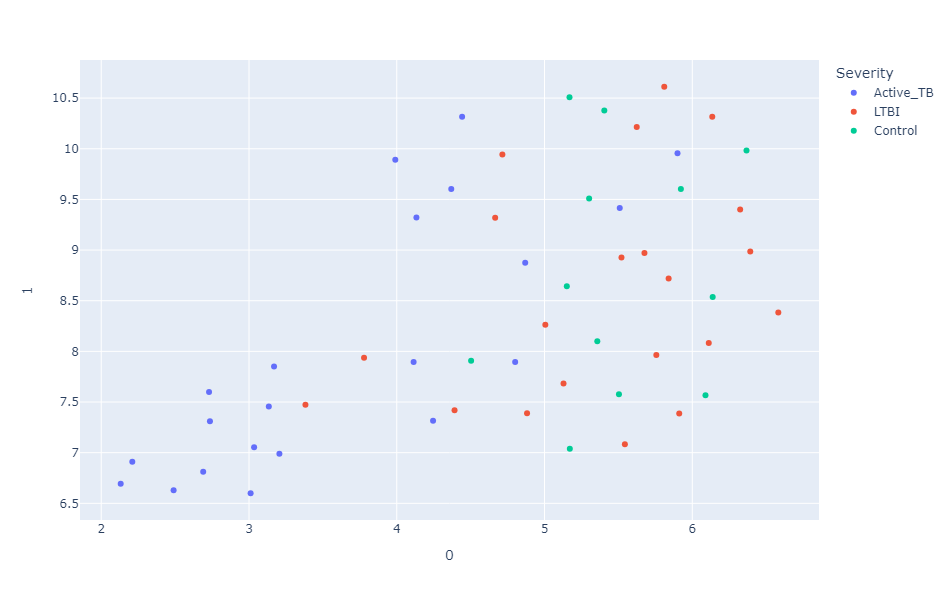

In [470]:
# doing uMAP clustering
from umap import UMAP
import plotly.express as px

df = ldn

features = ldn

umap_2d = UMAP(n_components=2, init='random')

proj_2d = umap_2d.fit_transform(features)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=severity, labels={'color': 'Severity'},
    height=600,width=800
)

fig_2d.show()

Text(0, 0.5, 'PC2')

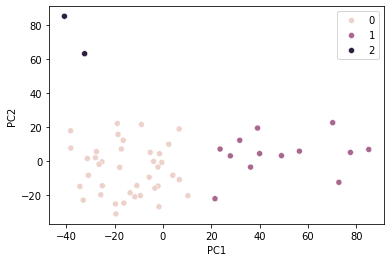

In [247]:
#trying kmeans clustering to see what groups come out
from sklearn.cluster import KMeans

# fit a kmeans model to our first_2_pcs objects; use n_clusters=2, random_state=2022, n_init=10
kmeanModel = KMeans(n_clusters=3,random_state=2022,n_init=10).fit(first_2_pcs) # !TO DO!

# grab the cluster labels from your kmeans model
kmeans_labels = kmeanModel.labels_ # !TO DO!

# remake the scatterplot from above, but color by kmeans_labels
ax = sns.scatterplot(x=first_2_pcs[:,0],y=first_2_pcs[:,1],hue=kmeans_labels) # !TO DO!
ax.set_xlabel("PC1"); ax.set_ylabel("PC2") # !TO DO!

In [500]:
#pls-da time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_data = ldn_count_df.T #put features on the cols, samples on rows
Y = severity

Y_prob = np.array([(Y == 'Control'), (Y == 'Active_TB'), (Y == 'LTBI')]).T
Y_prob = Y_prob.astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y, test_size=0.3, random_state=13)

Y_train_prob = np.array([(Y_train == 'Control'), (Y_train == 'Active_TB'), (Y_train == 'LTBI')]).T
Y_train_prob = Y_train_prob.astype(int)

Y_test_prob = np.array([(Y_test == 'Control'), (Y_test == 'Active_TB'), (Y_test == 'LTBI')]).T
Y_test_prob = Y_test_prob.astype(int)
Y_test_prob = np.argmax(Y_test_prob, axis=1)

ValueError: Found input variables with inconsistent numbers of samples: [42, 54]

In [472]:
from sklearn.metrics import accuracy_score, confusion_matrix
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)
model.fit(X_train,Y_train_prob)

Y_pred_prob = np.argmax(model.predict(X_test), axis=1)

acc1 = accuracy_score(Y_test_prob, Y_pred_prob) # TODO
print(f"PLS regression accuracy {acc1}")

cm = confusion_matrix(Y_test_prob, Y_pred_prob) # TODO
print(cm)

PLS regression accuracy 0.7058823529411765
[[1 1 2]
 [0 4 2]
 [0 0 7]]


Text(32.09375, 0.5, 'True')

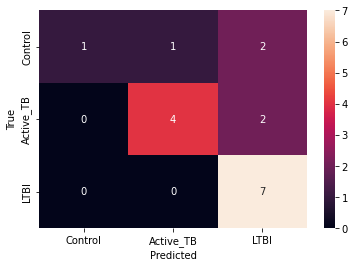

In [473]:
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", xticklabels=['Control', 'Active_TB', 'LTBI'], yticklabels=['Control', 'Active_TB', 'LTBI'])
plt.xlabel('Predicted')
plt.ylabel('True')

In [258]:
# 10 fold cross val
kf = KFold(n_splits=10) 
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)

curX = X_data.values
curY = Y_prob

accuracy_scores = []
r2_values = []

predY = np.zeros(Y_prob.shape)
for train_index, test_index in kf.split(curX):
    trainX = curX[train_index]
    testX = curX[test_index]
    trainY = curY[train_index] # TODO
    testY = curY[test_index]
    
    model.fit(trainX, trainY)
    predY[test_index] = model.predict(testX) # TODO

    Y_pred_classes = np.argmax(predY[test_index], axis=1)
    Y_test_classes = np.argmax(Y_prob[test_index], axis=1)
    
    # Calculate accuracy score
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    accuracy_scores.append(accuracy)

print(f'accuracy scores: {accuracy_scores}')

avg_accuracy = np.average(accuracy_scores)
print(f'average accuracy: {avg_accuracy}')

accuracy scores: [0.5, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.4, 1.0, 0.6, 0.4, 0.8, 0.0]
average accuracy: 0.62


## using ldn as a training set and south africa as a test set

In [474]:
control_samps = ldn_samp_df[ldn_samp_df['group'] == 'Control']
# print(control_samps)

# control_rows = ldn_X_train.index.intersection(control_samps['title'])
# print(control_rows)

control_samps_idx = control_samps['title']
# print(control_samps_idx)

# ldn_count_df = ldn_count_df[~ldn_count_df.columns.isin(control_samps['title'])]
columns_to_keep = [col for col in ldn_count_df.columns if col not in control_samps['title'].values]
ldn_count_df = ldn_count_df[columns_to_keep]

In [475]:
ldn_severity = ldn_severity[~(ldn_severity == 'Control')]
print(ldn_severity)

['Active_TB' 'Active_TB' 'LTBI' 'LTBI' 'Active_TB' 'LTBI' 'Active_TB'
 'Active_TB' 'LTBI' 'LTBI' 'LTBI' 'LTBI' 'Active_TB' 'LTBI' 'Active_TB'
 'LTBI' 'Active_TB' 'LTBI' 'Active_TB' 'Active_TB' 'Active_TB' 'LTBI'
 'LTBI' 'Active_TB' 'LTBI' 'LTBI' 'LTBI' 'Active_TB' 'LTBI' 'Active_TB'
 'Active_TB' 'LTBI' 'LTBI' 'Active_TB' 'Active_TB' 'Active_TB' 'Active_TB'
 'Active_TB' 'Active_TB' 'LTBI' 'LTBI' 'LTBI']


In [476]:
# using south africa as a test set
ldn_X_train = ldn_count_df.T
ldn_X_train.rename(columns=lambda x: x.strip(), inplace=True)

sa_X_test = sa_count_df.T
sa_X_test.rename(columns=lambda x: x.strip(), inplace=True)

common_columns = ldn_X_train.columns.intersection(sa_X_test.columns)

# limit ldn_X_train to only have the genes that sa_X_test has
ldn_X_train = ldn_X_train.drop(columns=ldn_X_train.columns.difference(common_columns))
sa_X_test = sa_X_test.drop(columns=sa_X_test.columns.difference(common_columns))

#prune the control samples from ldn_X_train
# ldn_X_train = ldn_X_train.drop(index=ldn_X_train.index.intersection(control_rows))

ldn_severity = np.array(ldn_samp_df['group'].tolist())
ldn_severity = ldn_severity[~(ldn_severity == 'Control')]
ldn_Y_train = np.array([(ldn_severity == 'Active_TB'), (ldn_severity == 'LTBI')]).T# want the vectors that represent the severities
ldn_Y_train = ldn_Y_train.astype(int)
# ldn_Y_train = ldn_Y_train[~(ldn_Y_train == [1, 0, 0]).all(axis=1)]

sa_severity = np.array(sa_samp_df['group'].tolist())
sa_Y_test = np.array([(sa_severity == 'Active_TB'), (sa_severity == 'LTBI')]).T
sa_Y_test = sa_Y_test.astype(int)

sa_Y_test_prob = np.argmax(sa_Y_test, axis=1)

In [477]:
from sklearn.metrics import accuracy_score, confusion_matrix
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)
model.fit(ldn_X_train, ldn_Y_train)

sa_Y_pred_prob = np.argmax(model.predict(sa_X_test), axis=1)

acc1 = accuracy_score(sa_Y_test_prob, sa_Y_pred_prob) # TODO
print(f"PLS regression accuracy {acc1}")

cm = confusion_matrix(sa_Y_test_prob, sa_Y_pred_prob) # TODO
print(cm)

PLS regression accuracy 0.7446808510638298
[[15  1]
 [11 20]]


Text(32.09375, 0.5, 'True')

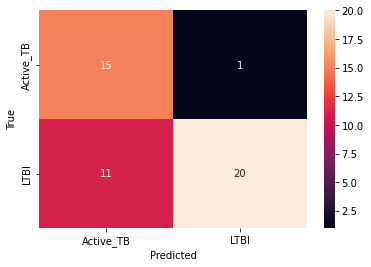

In [478]:
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", xticklabels=['Active_TB', 'LTBI'], yticklabels=['Active_TB', 'LTBI'])
plt.xlabel('Predicted')
plt.ylabel('True')

In [392]:
# loadings should be dependent on the X dataset that the model is trained from
# print(ldn_X_train)

In [424]:
loadings_df.head()

,Latent Variable 1,Latent Variable 2
ENSG00000000419,0.002836,0.006937
ENSG00000000457,0.002954,0.002409
ENSG00000000460,-0.002859,-0.002259
ENSG00000000938,0.008147,-0.006304
ENSG00000000971,-0.008735,0.006135


In [425]:
loadings_df.to_csv(r'C:\Users\jeann\Desktop\sp24-urop\finalproj\ldn_loadings_df.csv')

In [426]:
loadings_new_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/ldn_loadings_genesymbols.csv', index_col=0)

In [430]:
loadings_new_df = loadings_new_df.rename({'Latent.Variable.1':'Latent Variable 1', 'Latent.Variable.2':'Latent Variable 2'}, axis='columns')

Text(0, 0.5, 'Features')

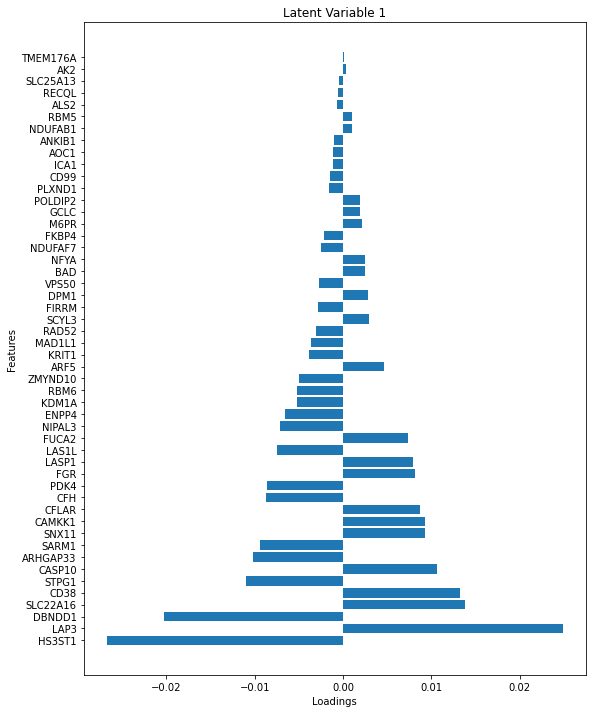

In [480]:
# plot the highest ranked loadings and extract biological significance
# loadings = model.x_loadings_
# loadings_df = pd.DataFrame(data=loadings[0:50, :], index=ldn_X_train.columns.values[0:50],columns=['Latent Variable {}'.format(x + 1) for x in range(2)])

loadings_LV1 = loadings_new_df.iloc[loadings_new_df["Latent Variable 1"].abs().argsort()[::-1]]

fig, ax = plt.subplots(figsize =(9, 12))

# Horizontal Bar Plot
ax.barh(loadings_LV1.index, loadings_LV1.iloc[:,0])
ax.set_title("Latent Variable 1")
ax.set_xlabel("Loadings")
ax.set_ylabel("Features")
# print(loadings)

Text(0, 0.5, 'Features')

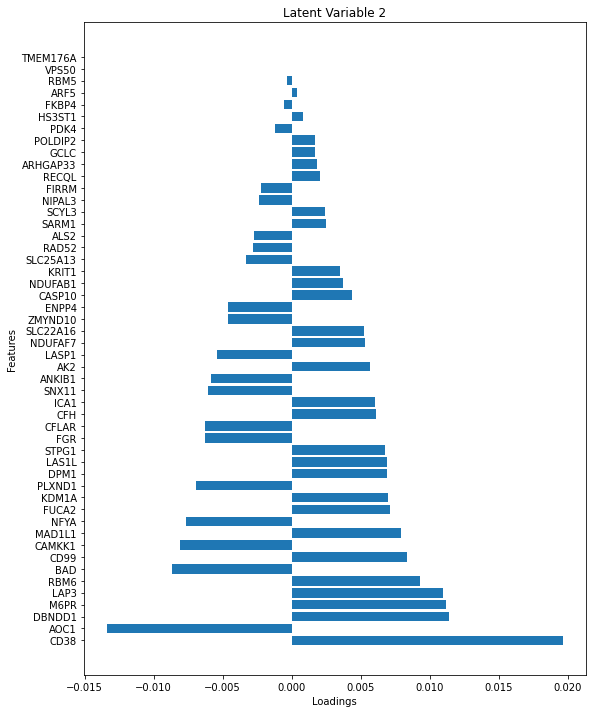

In [481]:
loadings_LV2 = loadings_new_df.iloc[loadings_new_df["Latent Variable 2"].abs().argsort()[::-1]]

fig, ax = plt.subplots(figsize =(9, 12))

ax.barh(loadings_LV2.index, loadings_LV2.iloc[:,1])
ax.set_title("Latent Variable 2")
ax.set_xlabel("Loadings")
ax.set_ylabel("Features")

In [488]:
gene_list = loadings_LV2.index.tolist()
' '.join(gene_list)
# gene_list.replace("'", "")
# gene_list.replace(",","")

'CD38 AOC1 DBNDD1 M6PR LAP3 RBM6 BAD CD99 CAMKK1 MAD1L1 NFYA FUCA2 KDM1A PLXND1 DPM1 LAS1L STPG1 FGR CFLAR CFH ICA1 SNX11 ANKIB1 AK2 LASP1 NDUFAF7 SLC22A16 ZMYND10 ENPP4 CASP10 NDUFAB1 KRIT1 SLC25A13 RAD52 ALS2 SARM1 SCYL3 NIPAL3 FIRRM RECQL ARHGAP33 GCLC POLDIP2 PDK4 HS3ST1 FKBP4 ARF5 RBM5 VPS50 TMEM176A'

In [485]:
print(gene_list)

['CD38', 'AOC1', 'DBNDD1', 'M6PR', 'LAP3', 'RBM6', 'BAD', 'CD99', 'CAMKK1', 'MAD1L1', 'NFYA', 'FUCA2', 'KDM1A', 'PLXND1', 'DPM1', 'LAS1L', 'STPG1', 'FGR', 'CFLAR', 'CFH', 'ICA1', 'SNX11', 'ANKIB1', 'AK2', 'LASP1', 'NDUFAF7', 'SLC22A16', 'ZMYND10', 'ENPP4', 'CASP10', 'NDUFAB1', 'KRIT1', 'SLC25A13', 'RAD52', 'ALS2', 'SARM1', 'SCYL3', 'NIPAL3', 'FIRRM', 'RECQL', 'ARHGAP33', 'GCLC', 'POLDIP2', 'PDK4', 'HS3ST1', 'FKBP4', 'ARF5', 'RBM5', 'VPS50', 'TMEM176A']


### south africa as training (pca exploration first)

Text(0, 0.5, 'Variance Explained')

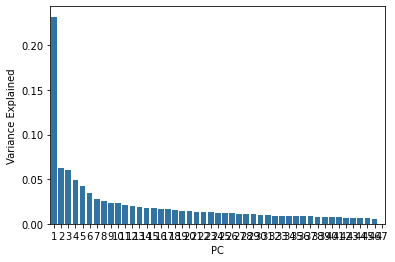

In [332]:
sa = sa_count_df.values
sa_severity = np.array(sa_samp_df['group'].tolist())
sa = sa.T
pca = decomposition.PCA(n_components = 47)
pca.fit(sa)
sa_transformed = pca.transform(sa)

explained_variance = pca.explained_variance_ratio_

ax = sns.barplot(y=explained_variance, x = [str(x+1) for x in np.arange(len(explained_variance))])
ax.set_xlabel("PC")
ax.set_ylabel("Variance Explained")

this looks better than the london PCA data.

In [ ]:
first_2_pcs = sa_transformed[:, 0:2]

ax = sns.scatterplot(x = first_2_pcs[:, 0], y = first_2_pcs[:, 1], hue = severity)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

In [ ]:
#trying kmeans clustering to see what groups come out
from sklearn.cluster import KMeans

# fit a kmeans model to our first_2_pcs objects; use n_clusters=2, random_state=2022, n_init=10
kmeanModel = KMeans(n_clusters=3,random_state=2022,n_init=10).fit(first_2_pcs) # !TO DO!

# grab the cluster labels from your kmeans model
kmeans_labels = kmeanModel.labels_ # !TO DO!

# remake the scatterplot from above, but color by kmeans_labels
ax = sns.scatterplot(x=first_2_pcs[:,0],y=first_2_pcs[:,1],hue=kmeans_labels) # !TO DO!
ax.set_xlabel("PC1"); ax.set_ylabel("PC2") # !TO DO!

## combine and 10 fold cross val

In [ ]:
ldn_count_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE140945_mouse_count_df.csv')
ldn_samp_df = pd.read_csv('C:/Users/jeann/Desktop/sp24-urop/finalproj/GSE140945_mouse_samp_df.csv')

In [378]:
sa_X_test.head()

Genes,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,...,ENSG00000282939,ENSG00000282988,ENSG00000283041,ENSG00000283050,ENSG00000283063,ENSG00000283103,ENSG00000283199,ENSG00000283602,ENSG00000283633,ENSG00000283652
Berry_SouthAfrica_Sample1,4.536061,4.320579,2.861886,9.301153,1.319594,3.944724,3.474550,4.861209,2.346926,4.978195,...,1.775437,-0.130017,7.883129,1.938320,1.221746,1.440518,3.352716,0.624073,4.613662,2.588529
Berry_SouthAfrica_Sample2,4.951775,4.314557,1.972661,9.266000,1.972661,4.503852,3.867098,5.035971,0.863036,5.087945,...,3.574283,0.250697,7.976191,-0.410886,0.407667,2.116093,2.490749,1.634302,4.561806,2.565977
Berry_SouthAfrica_Sample3,5.084165,4.560832,1.828115,9.982934,1.681096,4.086775,3.814322,5.222571,0.910578,4.437007,...,2.141030,-0.565451,7.450345,1.153036,-1.591923,0.792741,2.322075,1.970602,5.171351,3.174790
Berry_SouthAfrica_Sample4,4.297455,4.436117,2.050090,10.094174,-0.344902,3.581837,3.642159,5.246681,1.123021,4.473784,...,1.067792,1.512433,7.129884,2.643340,-6.611688,2.006697,1.583069,1.252498,4.065150,3.492911
Berry_SouthAfrica_Sample6,5.816510,5.097297,0.975978,10.748330,0.185073,4.590418,3.909966,5.499540,-1.399889,3.593656,...,-0.119781,2.735270,6.992633,2.132606,-5.792207,1.520676,0.138531,2.629858,6.092346,1.556522


In [377]:
ldn_X_train.head()

Genes,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,...,ENSG00000282939,ENSG00000282988,ENSG00000283041,ENSG00000283050,ENSG00000283063,ENSG00000283103,ENSG00000283199,ENSG00000283602,ENSG00000283633,ENSG00000283652
Berry_London_Sample1,4.647009,4.684619,2.379097,10.272479,1.927926,4.575402,4.192992,5.359207,1.028855,4.550721,...,1.734285,2.217433,6.552134,3.089308,0.609479,1.600761,1.529060,2.228793,2.754075,3.977591
Berry_London_Sample2,4.193344,4.633853,2.107392,10.032204,1.873832,4.485706,3.709367,5.484224,1.267586,4.740322,...,3.251415,-0.004667,7.152408,2.613210,2.177537,1.407594,1.504347,1.955959,3.358828,4.473807
Berry_London_Sample3,3.887871,4.358676,2.233367,10.117594,2.167779,4.638351,3.745266,5.174752,1.178920,5.359900,...,2.574404,0.285835,6.826765,2.574404,0.285835,1.695711,2.557431,1.632285,3.527239,4.584912
Berry_London_Sample4,4.603721,4.707055,1.891003,9.846276,1.528433,4.412240,3.769630,5.221303,1.659677,4.895766,...,2.864036,1.384043,7.295086,2.463187,1.659677,2.155309,2.022247,2.345569,3.053274,4.301740
Berry_London_Sample7,4.473330,4.603616,2.335626,10.108841,2.586106,4.287401,3.701868,5.597649,1.331208,4.881081,...,2.693286,1.883346,6.701226,3.256275,1.482325,1.348802,1.015902,2.344423,2.880325,4.148643


In [ ]:
combined_count_df = pd.merge(ldn_X_train, sa_X_test, how='inner')
combined_count_df.head()
# decided to only do the two groups of disease severity

In [ ]:
# 10 fold cross val
kf = KFold(n_splits=10) 
ncomp = 2
model = PLSRegression(n_components=ncomp, scale=False)

curX = X_data.values
curY = Y_prob

accuracy_scores = []
r2_values = []

predY = np.zeros(Y_prob.shape)
for train_index, test_index in kf.split(curX):
    trainX = curX[train_index]
    testX = curX[test_index]
    trainY = curY[train_index] # TODO
    testY = curY[test_index]
    
    model.fit(trainX, trainY)
    predY[test_index] = model.predict(testX) # TODO

    Y_pred_classes = np.argmax(predY[test_index], axis=1)
    Y_test_classes = np.argmax(Y_prob[test_index], axis=1)
    
    # Calculate accuracy score
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    accuracy_scores.append(accuracy)

print(f'accuracy scores: {accuracy_scores}')

avg_accuracy = np.average(accuracy_scores)
print(f'average accuracy: {avg_accuracy}')

# notes

can plot the predicted vs actual testing data to see how well the model predicts, want to see a 45 deg line

to get the biological insights from scores plot, find specific treatments (extreme? or just that one treatment) and see in what direction the vector goes -- which latent variable describes it. then see what the latent variable is a function of. check lauffenburger paper for example
- tells you there are multiple routes to the cell death protection by going back and seeing the data
- for example, the cell could be adding together ERK and Akt (algebraic) or a logical OR (ERK or Akt is upregulated)

biological insights from loadings plot:
- plot one gene activity on the loading plot, and see how its trend explains the effect of that gene on the axes (early can be pro-survival, late is pro-death)

using predictive power to predict new data

- can look at the coefficient of certain features (genes) to see how much it contributes to the final phenotype


- can do batch correction to combine london and south africa data

- what is the transcriptomic signature in the lung or the blood?

- what strain infected you based on samples from lung, blood, or blood array

- tells you which cell population is predictive of which strain

- lung transcriptomic signatures are morep redictive of which staring infected you than the blood

- what separates latent infection from active infection?

- after making the human model, try to use the mouse samples (having filtered out for common genes) and see which disease state it is in

- to tSNE or umap to see if clustering is slightly better for the human london data
- analyzing the biological significance of my model (PC analysis or LV analysis), which are most up in my samples -- which are weighted highest
- rank loadings (by first or second comp, by average of the two), pull out top 50 features/20/100, look at those
- after making the human model, try to use the mouse samples (having filtered out for common genes) and see which disease state it is in